## Setup and Data Loading

In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
import importlib

sys.path.append('../scripts/')
import FeatureEngineering
importlib.reload(FeatureEngineering)


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:

path = '../data/consolidated/'
weather_data = pd.read_csv(path+'consolidated_weather_from_centroids.csv')
demand_data = pd.read_csv(path+'consolidatedIESOdemand.csv')
price_data = pd.read_csv(path+'prices_zonal.csv')

# convert temperature
columns = list(weather_data.columns)
columns[0] = 'Hour'
weather_data.columns = columns
weather_data['temp_C_t2m'] = weather_data['t2m'] - 273.15

# create proper dataset
dataset = FeatureEngineering.CleanedDataset(weather_data, demand_data, price_data)
datamerged = dataset.merge_datasets()
datamerged = dataset.add_calendar_features(datamerged)

print(f"Dataset shape: {datamerged.shape}")

/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_18104/3273825869.py:3: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  demand_data = pd.read_csv(path+'consolidatedIESOdemand.csv')


Dataset shape: (1905110, 46)


In [4]:
#create dummy variables for hour, month, weekday


print(datamerged.head())
print(datamerged.columns)


datamerged['Date'] = pd.to_datetime(datamerged['Date'])

# create dummy variables for hour, month, weekday
datamerged['hour'] = datamerged['Date'].dt.hour
datamerged['month'] = datamerged['Date'].dt.month
datamerged['weekday'] = datamerged['Date'].dt.weekday

# one hot
dummies = pd.get_dummies(datamerged[['hour', 'month', 'weekday']], columns=['hour', 'month', 'weekday'], prefix=['hour', 'month', 'weekday'])


datamerged = pd.concat([datamerged, dummies], axis=1)


print(datamerged.columns)

print(datamerged.filter(regex='hour_|month_|weekday_').head())

datamerged = datamerged[
    (datamerged['Date'].dt.year >= 2018) & 
    (datamerged['Date'].dt.year <= 2024)
]

                 Date  Hour  Ontario Demand  Northwest  Northeast  Ottawa  \
0 2021-08-27 00:00:00     0           15722        421       1110    1035   
1 2021-08-27 01:00:00     1           14963        430       1098     967   
2 2021-08-27 02:00:00     2           14547        425       1083     925   
3 2021-08-27 03:00:00     3           14377        423       1058     915   
4 2021-08-27 04:00:00     4           14489        420       1007     937   

   East  Toronto  Essa  Bruce  Southwest  Niagara  West  Zone Total Diff  \
0   959     5893   969     86       3168      541  1774       15958  236   
1   883     5609   903     84       3017      521  1713       15225  262   
2   860     5424   856     83       2917      503  1673       14750  203   
3   843     5352   834     81       2882      503  1671       14562  185   
4   873     5464   844     77       2901      510  1695       14727  239   

   Year    u10     v10      d2m      t2m       ssrd     tp  latitude  \
0  2021 

## 1. Multicollinearity Analysis

### 1.1 Correlation Matrix

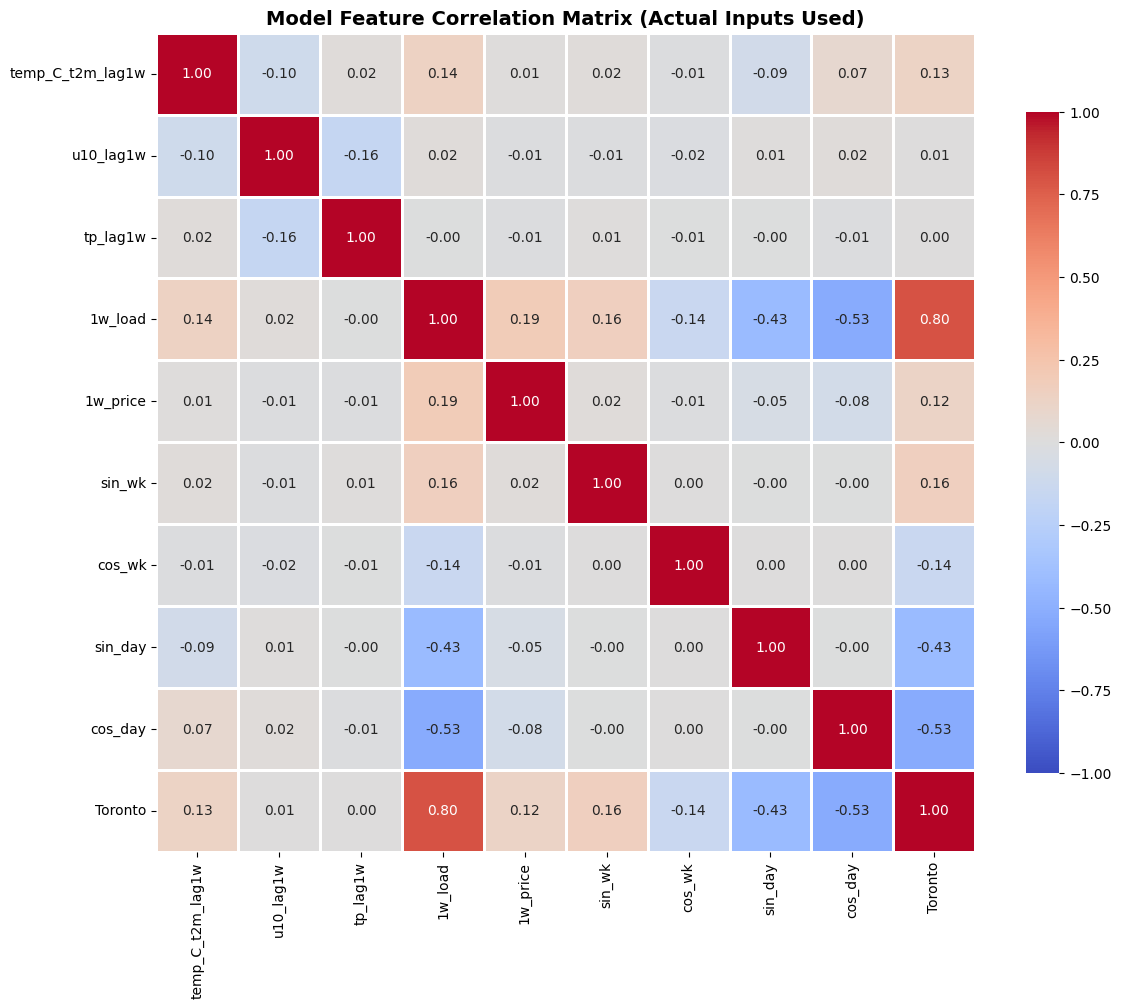


Highly correlated feature pairs (|r| > 0.7):
  1w_load <-> Toronto: 0.800


In [5]:
#feature engineering pipeline
import numpy as np

toronto_data = datamerged[datamerged['file'] == 'Toronto_centroid_weather'].copy()
toronto_data['Date'] = pd.to_datetime(toronto_data['Date'])
toronto_data = toronto_data[(toronto_data['Date'].dt.year >= 2018) & 
                            (toronto_data['Date'].dt.year <= 2024)]
toronto_data = toronto_data.set_index('Date').sort_index()

# fourier
toronto_data["t"] = np.arange(len(toronto_data))
period_weekly = 24 * 7
toronto_data["sin_wk"] = np.sin(2 * np.pi * toronto_data["t"] / period_weekly)
toronto_data["cos_wk"] = np.cos(2 * np.pi * toronto_data["t"] / period_weekly)
toronto_data["sin_day"] = np.sin(2 * np.pi * toronto_data["t"] / 24)
toronto_data["cos_day"] = np.cos(2 * np.pi * toronto_data["t"] / 24)

# lagged weather vars
toronto_data['temp_C_t2m_lag1w'] = toronto_data['temp_C_t2m'].shift(168)
toronto_data['u10_lag1w'] = toronto_data['u10'].shift(168)
toronto_data['tp_lag1w'] = toronto_data['tp'].shift(168)

# lagged load and price
toronto_data['1w_load'] = toronto_data['Toronto'].shift(168)
toronto_data['1w_price'] = toronto_data['Toronto_Darlington'].shift(168)

# drop nan
toronto_data = toronto_data.dropna(subset=['temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w', '1w_load', '1w_price'])

# select model features for correlation analysis (lagged versions + Fourier + current load)
model_continuous_features = [
    'temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w',  # Lagged weather (used in models)
    '1w_load', '1w_price',  # Lagged load and price
    'sin_wk', 'cos_wk', 'sin_day', 'cos_day',  # Fourier terms
    'Toronto'  # Target for reference
]
correlation_matrix = toronto_data[model_continuous_features].corr()

#heaptmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Model Feature Correlation Matrix (Actual Inputs Used)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#highly correlated pairs
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((correlation_matrix.columns[i], 
                            correlation_matrix.columns[j], 
                            correlation_matrix.iloc[i, j]))

print("\nHighly correlated feature pairs (|r| > 0.7):")
for feat1, feat2, corr in high_corr:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

### 1.2 Variance Inflation Factor (VIF)

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# prepare features for VIF calculation 
vif_features = [
    'temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w',
    '1w_load', '1w_price',
    'sin_wk', 'cos_wk', 'sin_day', 'cos_day'
]
X_vif = toronto_data[vif_features].dropna()

# calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = vif_features
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(vif_features))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("Variance Inflation Factors (Model Features):")
print(vif_data.to_string(index=False))
print("\nInterpretation:")
print("  VIF < 5: Low multicollinearity")
print("  5 ≤ VIF < 10: Moderate multicollinearity")
print("  VIF ≥ 10: High multicollinearity (potential concern)")

# check dummy variable multicollinearity
print("\n" + "="*80)
print("DUMMY VARIABLE MULTICOLLINEARITY")
print("="*80)
print("\nNote: One-hot encoded categorical variables have inherent multicollinearity:")
print("  - Hour dummies: 23 features (hour_1 to hour_23, reference=hour_0)")
print("  - Month dummies: 11 features (month_2 to month_12, reference=month_1)")
print("  - Weekday dummies: 6 features (weekday_1 to weekday_6, reference=weekday_0)")
print("\nThis is expected and addressed by dropping one reference category.")
print("VIF for dummy variables would be extremely high - not meaningful to calculate.")

Variance Inflation Factors (Model Features):
         Feature    VIF
         1w_load 2.4931
temp_C_t2m_lag1w 2.0284
        1w_price 1.1820
       u10_lag1w 1.1319
        tp_lag1w 1.1074
         cos_day 1.0405
         sin_day 1.0076
          sin_wk 1.0014
          cos_wk 1.0008

Interpretation:
  VIF < 5: Low multicollinearity
  5 ≤ VIF < 10: Moderate multicollinearity
  VIF ≥ 10: High multicollinearity (potential concern)

DUMMY VARIABLE MULTICOLLINEARITY

Note: One-hot encoded categorical variables have inherent multicollinearity:
  - Hour dummies: 23 features (hour_1 to hour_23, reference=hour_0)
  - Month dummies: 11 features (month_2 to month_12, reference=month_1)
  - Weekday dummies: 6 features (weekday_1 to weekday_6, reference=weekday_0)

This is expected and addressed by dropping one reference category.
VIF for dummy variables would be extremely high - not meaningful to calculate.


## 2. Feature Preparation with Groups

Based on correlation/VIF analysis, define feature groups for removal experiments

In [ ]:
# from training_testing_rq1.ipynb notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

# ============================================================================
# Reusable Data Preparation Pipeline should work for all the data models
# ============================================================================

def prepare_toronto_load_data(
    datamerged,
    zone='Toronto_centroid_weather',
    weather_vars=None,
    extra_lags=None,  # list of tuples: (original_col, new_name, lag_hours)
    test_weeks=1,
    include_daily_seasonality=True
):
    """
    Prepare Toronto load data for time series modeling.
    
    parameters:
    datamerged : pd.DataFrame
        The merged dataset with all features
    zone : str
        Location identifier to filter by
    weather_vars : list, optional
        List of weather variables to use.
    extra_lags : list of tuples, optional
        Each tuple: (column_name, new_column_name, lag_hours)
    test_weeks : int
        Number of weeks for test set (default: 1 week = 168 hours)
    include_daily_seasonality : bool
        Whether to include daily sin/cos features (default: True)
    
    Returns:
    --------
    dict containing:
        - 'train': training dataset with datetime index
        - 'test': test dataset with datetime index
        - 'target_train': target variable for training
        - 'target_test': target variable for testing
        - 'exog_features': list of exogenous feature column names
        - 'toronto_data': full processed dataset
    """
    
    if weather_vars is None:
        weather_vars = ['temp_C_t2m', 'u10', 'tp']
    if extra_lags is None:
        extra_lags = []
    
    hours_per_week = 168
    
    # filter and prepare
    toronto_data = datamerged[datamerged['file'] == zone].copy()
    toronto_data['Date'] = pd.to_datetime(toronto_data['Date'])
    toronto_data = toronto_data.set_index('Date').sort_index()
    
    # time index for fourier terms
    toronto_data["t"] = np.arange(len(toronto_data))
    
    # weekly seasonality
    period_weekly = 24 * 7
    toronto_data["sin_wk"] = np.sin(2 * np.pi * toronto_data["t"] / period_weekly)
    toronto_data["cos_wk"] = np.cos(2 * np.pi * toronto_data["t"] / period_weekly)
    
    # daily seasonality 
    if include_daily_seasonality:
        toronto_data["sin_day"] = np.sin(2 * np.pi * toronto_data["t"] / 24)
        toronto_data["cos_day"] = np.cos(2 * np.pi * toronto_data["t"] / 24)
    
    # lag weather variables by 1 week
    for var in weather_vars:
        toronto_data[f'{var}_lag1w'] = toronto_data[var].shift(168)
    
    # lag extra columns by custom hours
    for col, new_name, lag_hours in extra_lags:
        toronto_data[new_name] = toronto_data[col].shift(lag_hours)
    
    # drop rows with NaN after lagging. this happens at the start sometimes.
    cols_to_check = [f'{v}_lag1w' for v in weather_vars] + ['Toronto']
    if extra_lags:
        cols_to_check += [new_name for _, new_name, _ in extra_lags]
    toronto_data = toronto_data.dropna(subset=cols_to_check)
    
    # e xtract dummy variables 
    hour_dummies = [c for c in toronto_data.columns if c.startswith('hour_')][1:]
    month_dummies = [c for c in toronto_data.columns if c.startswith('month_')][1:]
    weekday_dummies = [c for c in toronto_data.columns if c.startswith('weekday_')][1:]
    
    # bild exogenous features list ---
    seasonal_features = ["sin_wk", "cos_wk"]
    if include_daily_seasonality:
        seasonal_features += ['sin_day', 'cos_day']

    exog_features = (
        hour_dummies +
        month_dummies +
        weekday_dummies +
        [f'{v}_lag1w' for v in weather_vars] +
        seasonal_features
    )
    
    # holidays addition
    if 'IsHoliday' in toronto_data.columns:
        exog_features += ['IsHoliday']
    
    if extra_lags:
        exog_features += [new_name for _, new_name, _ in extra_lags]

    # Ensure all feature columns are numeric before splitting
    for col in exog_features:
        toronto_data[col] = pd.to_numeric(toronto_data[col], errors='coerce')
    toronto_data[exog_features] = toronto_data[exog_features].fillna(0)
    
    # train/test split
    train = toronto_data.iloc[:-hours_per_week * test_weeks]
    test = toronto_data.iloc[-hours_per_week * test_weeks:]
    
    # ensure numeric for exogenous features
    for df in [train, test]:
        df[exog_features] = df[exog_features].astype(float)
    
    target_train = train['Toronto'].astype(float)
    target_test = test['Toronto'].astype(float)
    
    return {
        'train': train,
        'test': test,
        'target_train': target_train,
        'target_test': target_test,
        'exog_features': exog_features,
        'toronto_data': toronto_data
    }

print("Data preparation function loaded")

/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Data preparation function loaded


## 3. Feature Importance by Model

### 3.1 Bayesian Ridge Regression: Coefficient Analysis

In [8]:
# prepare data


data = prepare_toronto_load_data(
    datamerged,
    zone='Toronto_centroid_weather',
    weather_vars=['temp_C_t2m', 'u10', 'tp'],
    extra_lags=[
        ('Toronto', '1w_load', 168),
        ('Toronto_Darlington', '1w_price', 168)
    ],
    test_weeks=40,
    include_daily_seasonality=True
)
#only train on years 2018-2024

train = data['train']
test = data['test']
target_train = data['target_train']
target_test = data['target_test']
exog_features = data['exog_features']

# train model brr
scaler = StandardScaler()
# the model only ever sees the train's mean -- NOT TEST. so this is not data leakage. 
# the standardization is not performed on data it hasn't seen in test. it uses train's sample mean.
X_train_scaled = scaler.fit_transform(train[exog_features].astype(float))
X_test_scaled = scaler.transform(test[exog_features].astype(float))

model = BayesianRidge()
model.fit(X_train_scaled, target_train)

# analyze coefficients
feature_importance = pd.DataFrame({
    'Feature': exog_features,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 20 Most Important Features (Bayesian Ridge):")
print(feature_importance.head(20).to_string(index=False))

/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_18104/3804223725.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_18104/3804223725.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].astype(float)



Top 20 Most Important Features (Bayesian Ridge):
  Feature  Coefficient  Abs_Coefficient
  cos_day    -300.8835         300.8835
  1w_load     286.6756         286.6756
  month_4    -161.7987         161.7987
 month_10    -153.8572         153.8572
  month_5    -146.8620         146.8620
  sin_day    -144.3456         144.3456
weekday_6    -116.9586         116.9586
  hour_20     109.7059         109.7059
  hour_19     107.5019         107.5019
weekday_5    -105.8326         105.8326
  month_7     105.3269         105.3269
  hour_18      97.9351          97.9351
IsHoliday     -97.5655          97.5655
  month_9     -94.4948          94.4948
  month_3     -94.0811          94.0811
  hour_21      90.9676          90.9676
 month_11     -84.5430          84.5430
   cos_wk     -84.2416          84.2416
  hour_17      82.5694          82.5694
weekday_3     -65.5432          65.5432


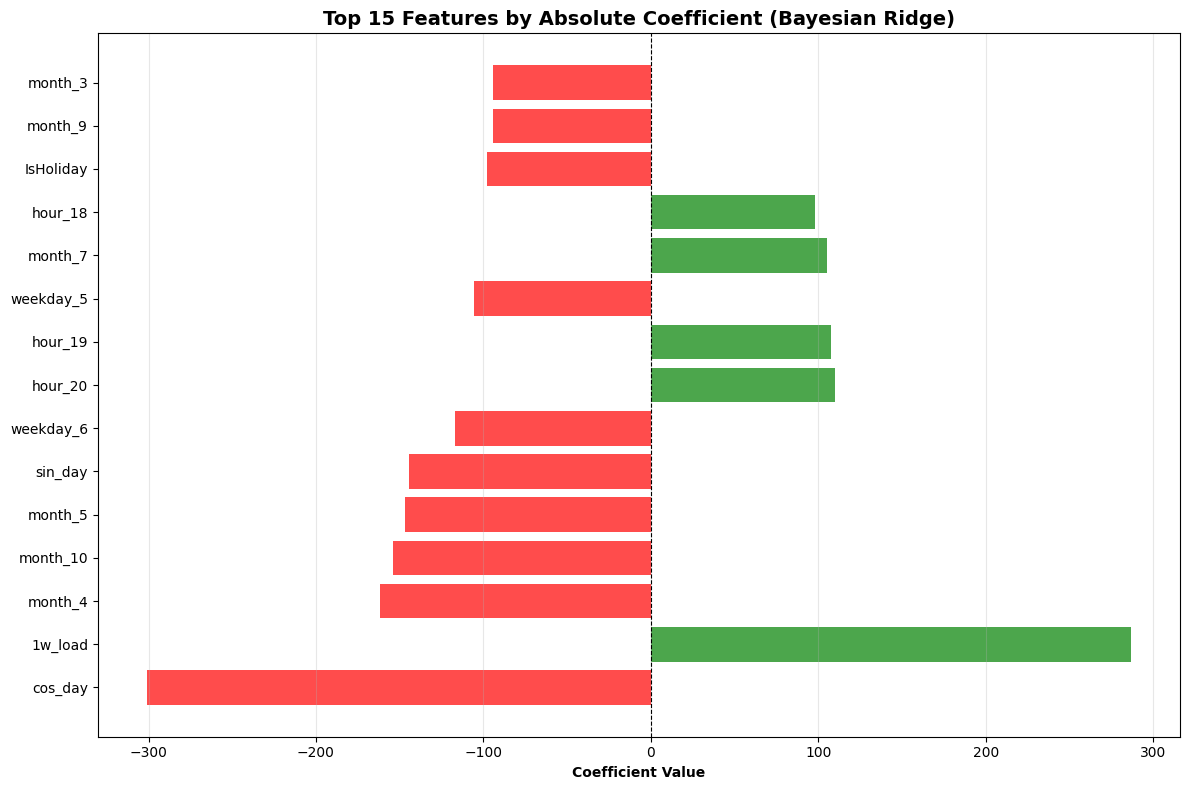

In [9]:
# visualize top features
top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontweight='bold')
plt.title(f'Top {top_n} Features by Absolute Coefficient (Bayesian Ridge)', 
          fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 ARIMAX: Coefficient Significance

In [10]:

forecast_horizon = 168  # 1 week
max_weeks = 40 # limit number of weeks to forecast

#fulld ataset
full_data = data['toronto_data']

# find initial training end index (start of test set)
initial_train_end = full_data.index.get_loc(test.index[0])

In [ ]:
# --- Rolling Forecast Evaluation for ARIMAX ---
print("\nStarting rolling forecast for ARIMAX...")
all_preds_arimax = []
all_actuals_arimax = []
max_weeks = 40
for week in range(max_weeks):
    current_train_end = initial_train_end + (week * forecast_horizon)
    forecast_end = current_train_end + forecast_horizon
    if forecast_end > len(full_data):
        forecast_end = len(full_data)

    expanding_train = full_data.iloc[:current_train_end]
    forecast_data = full_data.iloc[current_train_end:forecast_end]

    if forecast_data.empty:
        break

    y_train = expanding_train['Toronto'].astype(float)
    X_train = expanding_train[exog_features].astype(float)
    X_forecast = forecast_data[exog_features].astype(float)
    y_actual = forecast_data['Toronto'].astype(float)

    arimax_model = SARIMAX(
        y_train,
        exog=X_train,
        order=(2, 1, 1),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    arimax_results = arimax_model.fit(disp=False)
    
    # Forecast for the next week
    forecast = arimax_results.get_forecast(steps=len(X_forecast), exog=X_forecast)
    preds = forecast.predicted_mean
    
    all_preds_arimax.extend(preds)
    all_actuals_arimax.extend(y_actual.values)
    
    if (week + 1) % 10 == 0:
        print(f"  Week {week + 1}/{max_weeks} completed.")

# Get coefficients from the last trained model
params = arimax_results.params
pvalues = arimax_results.pvalues
exog_params = params[params.index.isin(exog_features)]
exog_pvalues = pvalues[pvalues.index.isin(exog_features)]

arimax_importance = pd.DataFrame({
    'Feature': exog_params.index,
    'Coefficient': exog_params.values,
    'P-value': exog_pvalues.values
}).sort_values('P-value')

print("\nTop 20 Most Significant Features (ARIMAX from last window):")
print(arimax_importance.head(20).to_string(index=False))

rmse_arimax = np.sqrt(mean_squared_error(all_actuals_arimax, all_preds_arimax))
print(f"\nRolling ARIMAX RMSE: {rmse_arimax:.2f} MW")


Starting rolling forecast for ARIMAX...


/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._

  Week 10/40 completed.


/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._

  Week 20/40 completed.


/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._

  Week 30/40 completed.


/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._

  Week 40/40 completed.

Top 20 Most Significant Features (ARIMAX from last window):
Feature  Coefficient  P-value
 hour_9      76.3106   0.0000
hour_21     133.4665   0.0000
hour_20     150.4554   0.0000
hour_19     121.1776   0.0000
sin_day    -180.6358   0.0000
hour_15     -77.2348   0.0000
 hour_7      93.3099   0.0000
 hour_8      93.8836   0.0000
cos_day    -257.5890   0.0000
hour_14     -92.3089   0.0000
1w_load       0.6611   0.0000
hour_13     -74.5307   0.0000
hour_18      79.5745   0.0000
hour_22      83.4966   0.0000
hour_10      47.5159   0.0000
 hour_6      49.7349   0.0000
hour_16     -27.8428   0.0000
hour_17      32.2809   0.0000
hour_23      33.6904   0.0000
hour_12     -35.4098   0.0000

Rolling ARIMAX RMSE: 731.82 MW


In [20]:
arimax_importance

,Feature,Coefficient,P-value
8,hour_9,76.3106,0.0000
20,hour_21,133.4665,0.0000
19,hour_20,150.4554,0.0000
18,hour_19,121.1776,0.0000
45,sin_day,-180.6358,0.0000
14,hour_15,-77.2348,0.0000
6,hour_7,93.3099,0.0000
7,hour_8,93.8836,0.0000
46,cos_day,-257.5890,0.0000
13,hour_14,-92.3089,0.0000


### 3.3 Prophet: Regressor Components

In [12]:
# rolling forecast evaluation forprophet 
print("\nStarting rolling forecast for Prophet...")

# emove Fourier terms
prophet_exog_features = [f for f in exog_features if 'sin' not in f and 'cos' not in f]

all_preds_prophet = []
all_actuals_prophet = []

# retrain for every week
for week in range(max_weeks):
    current_train_end = initial_train_end + (week * forecast_horizon)
    forecast_end = current_train_end + forecast_horizon
    if forecast_end > len(full_data):
        forecast_end = len(full_data)

    expanding_train = full_data.iloc[:current_train_end]
    forecast_data = full_data.iloc[current_train_end:forecast_end]

    if forecast_data.empty:
        break

    # repare training data for Prophet
    prophet_train_df = pd.DataFrame({
        'ds': expanding_train.index,
        'y': expanding_train['Toronto'].values
    })
    for col in prophet_exog_features:
        prophet_train_df[col] = expanding_train[col].values

    # initialize and fit Prophet model
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True
    )
    for col in prophet_exog_features:
        prophet_model.add_regressor(col)
    
    prophet_model.fit(prophet_train_df)

    # future dataframe for prediction
    future_df = pd.DataFrame({'ds': forecast_data.index})
    for col in prophet_exog_features:
        future_df[col] = forecast_data[col].values
        
    # forecast
    forecast = prophet_model.predict(future_df)
    preds = forecast['yhat'].values
    
    all_preds_prophet.extend(preds)
    all_actuals_prophet.extend(forecast_data['Toronto'].values)
    
    if (week + 1) % 10 == 0:
        print(f"  Week {week + 1}/{max_weeks} completed.")

# analyze regressor coefficients from the last model
from prophet.utilities import regressor_coefficients
regressor_coef = regressor_coefficients(prophet_model)
print("\nRegressor Coefficients (Prophet from last window):")
print(regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef').to_string(index=False))

rmse_prophet = np.sqrt(mean_squared_error(all_actuals_prophet, all_preds_prophet))
print(f"\nRolling Prophet RMSE: {rmse_prophet:.2f} MW")


Starting rolling forecast for Prophet...


14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:39:08 - cmdstanpy - INFO - Chain [1] done processing
14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:25 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:40 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing
14:39:56 - cmdstanpy - INFO - Chain [1] start processing
14:40:17 - cmdstanpy - INFO - Chain [1] done processing
14:40:19 - cmdstanpy - INFO - Chain [1] start processing
14:40:38 - cmdstanpy - INFO - Chain [1] done processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:55 - cmdstanpy - INFO - Chain [1] done processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:41:13 - cmdstanpy - INFO - Chain [1] done processing
14:41:16 - cmdstanpy - INFO - Chain [1] start processing
14:41:31 - cmdstanpy - INFO - Chain [1]

  Week 10/40 completed.


14:41:51 - cmdstanpy - INFO - Chain [1] start processing
14:42:15 - cmdstanpy - INFO - Chain [1] done processing
14:42:17 - cmdstanpy - INFO - Chain [1] start processing
14:42:39 - cmdstanpy - INFO - Chain [1] done processing
14:42:41 - cmdstanpy - INFO - Chain [1] start processing
14:43:02 - cmdstanpy - INFO - Chain [1] done processing
14:43:04 - cmdstanpy - INFO - Chain [1] start processing
14:43:25 - cmdstanpy - INFO - Chain [1] done processing
14:43:27 - cmdstanpy - INFO - Chain [1] start processing
14:43:47 - cmdstanpy - INFO - Chain [1] done processing
14:43:49 - cmdstanpy - INFO - Chain [1] start processing
14:44:14 - cmdstanpy - INFO - Chain [1] done processing
14:44:16 - cmdstanpy - INFO - Chain [1] start processing
14:44:36 - cmdstanpy - INFO - Chain [1] done processing
14:44:39 - cmdstanpy - INFO - Chain [1] start processing
14:44:57 - cmdstanpy - INFO - Chain [1] done processing
14:45:00 - cmdstanpy - INFO - Chain [1] start processing
14:45:20 - cmdstanpy - INFO - Chain [1]

  Week 20/40 completed.


14:45:46 - cmdstanpy - INFO - Chain [1] start processing
14:46:10 - cmdstanpy - INFO - Chain [1] done processing
14:46:13 - cmdstanpy - INFO - Chain [1] start processing
14:46:36 - cmdstanpy - INFO - Chain [1] done processing
14:46:39 - cmdstanpy - INFO - Chain [1] start processing
14:46:55 - cmdstanpy - INFO - Chain [1] done processing
14:46:57 - cmdstanpy - INFO - Chain [1] start processing
14:47:15 - cmdstanpy - INFO - Chain [1] done processing
14:47:17 - cmdstanpy - INFO - Chain [1] start processing
14:47:36 - cmdstanpy - INFO - Chain [1] done processing
14:47:39 - cmdstanpy - INFO - Chain [1] start processing
14:47:58 - cmdstanpy - INFO - Chain [1] done processing
14:48:00 - cmdstanpy - INFO - Chain [1] start processing
14:48:14 - cmdstanpy - INFO - Chain [1] done processing
14:48:17 - cmdstanpy - INFO - Chain [1] start processing
14:48:30 - cmdstanpy - INFO - Chain [1] done processing
14:48:32 - cmdstanpy - INFO - Chain [1] start processing
14:48:48 - cmdstanpy - INFO - Chain [1]

  Week 30/40 completed.


14:49:06 - cmdstanpy - INFO - Chain [1] start processing
14:49:22 - cmdstanpy - INFO - Chain [1] done processing
14:49:24 - cmdstanpy - INFO - Chain [1] start processing
14:49:39 - cmdstanpy - INFO - Chain [1] done processing
14:49:41 - cmdstanpy - INFO - Chain [1] start processing
14:49:54 - cmdstanpy - INFO - Chain [1] done processing
14:49:57 - cmdstanpy - INFO - Chain [1] start processing
14:50:12 - cmdstanpy - INFO - Chain [1] done processing
14:50:15 - cmdstanpy - INFO - Chain [1] start processing
14:50:33 - cmdstanpy - INFO - Chain [1] done processing
14:50:35 - cmdstanpy - INFO - Chain [1] start processing
14:50:52 - cmdstanpy - INFO - Chain [1] done processing
14:50:54 - cmdstanpy - INFO - Chain [1] start processing
14:51:11 - cmdstanpy - INFO - Chain [1] done processing
14:51:13 - cmdstanpy - INFO - Chain [1] start processing
14:51:31 - cmdstanpy - INFO - Chain [1] done processing
14:51:33 - cmdstanpy - INFO - Chain [1] start processing
14:51:53 - cmdstanpy - INFO - Chain [1]

  Week 40/40 completed.

Regressor Coefficients (Prophet from last window):
       regressor regressor_mode      coef
         month_9       additive -673.8333
       IsHoliday       additive -620.5617
        month_11       additive -543.7890
        month_12       additive -507.9795
        month_10       additive -493.3467
         month_8       additive -460.5323
         month_6       additive -398.0189
         month_7       additive -255.0553
       weekday_5       additive -246.1697
       weekday_6       additive -243.4966
         month_4       additive -195.9371
         month_5       additive -181.4822
       weekday_3       additive -133.3335
       weekday_4       additive -127.5220
         month_3       additive -114.4529
       weekday_2       additive  -90.6983
       weekday_1       additive  -65.6201
          hour_4       additive  -62.1959
          hour_5       additive  -46.0140
          hour_3       additive  -40.5856
          hour_2       additive  -15.1052


In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def prophet_permutation_importance(model, df, exog_features, metric=mean_absolute_error):
    """
    Compute permutation importance for a fitted Prophet model.
    
    Parameters:
        model: Fitted Prophet model
        df: DataFrame used for prediction (ds, y, and regressors)
        exog_features: List of regressor names
        metric: Error metric function (default MAE)
        
    Returns:
        Dictionary of feature: importance_score
    """
    
    # baseline predictioj
    baseline_pred = model.predict(df)
    baseline_err = metric(df['y'], baseline_pred['yhat'])

    importances = {}

    for col in exog_features:
        df_permuted = df.copy()
        df_permuted[col] = np.random.permutation(df_permuted[col])

        pred = model.predict(df_permuted)
        err = metric(df['y'], pred['yhat'])

        importances[col] = err - baseline_err  # Error increase

    return dict(sorted(importances.items(), key=lambda x: -x[1]))




# same dataset
importance_scores = prophet_permutation_importance(
    prophet_model,
    prophet_train_df,
    prophet_exog_features,
    metric=mean_absolute_error
)

importance_scores


{'1w_load': 70.02323706820664,
 'month_9': 56.53921571491071,
 'month_11': 45.13730287674639,
 'month_10': 40.421271424284896,
 'month_12': 38.40812097415915,
 'month_8': 28.215565013941784,
 'month_6': 23.563749904700558,
 'weekday_5': 14.94884711452454,
 'IsHoliday': 14.933460746391006,
 'weekday_6': 13.77121216024949,
 'temp_C_t2m_lag1w': 11.772465379850814,
 'month_7': 8.788323929071282,
 'month_5': 6.161754875840643,
 'month_4': 5.862523176006221,
 'weekday_3': 5.423749919392208,
 'weekday_4': 4.660588638277318,
 'weekday_2': 2.6987318495524164,
 'month_3': 1.7402148995388984,
 'weekday_1': 1.54954936490833,
 'hour_17': 0.5791911947712833,
 'hour_7': 0.4949260794064685,
 'hour_20': 0.3303296207393487,
 'hour_21': 0.3231494438049367,
 'hour_18': 0.26849880926016567,
 'hour_11': 0.25846619578646823,
 'hour_10': 0.17063763782920205,
 'hour_8': 0.16617184682337438,
 'hour_6': 0.1610732219600095,
 'hour_12': 0.15319285993916765,
 'hour_22': 0.1200598464681093,
 'hour_19': 0.10623733274

## 4. Feature Ablation Study

Systematically remove feature groups and measure performance degradation

In [14]:
# define feature groups
feature_groups = {
    'Weather': ['temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w'],
    'Price': ['1w_price'],
    'Historical Load': ['1w_load'],
    'Fourier (Weekly)': ['sin_wk', 'cos_wk'],
    'Fourier (Daily)': ['sin_day', 'cos_day'],
    'Hour Dummies': [c for c in exog_features if c.startswith('hour_')],
    'Month Dummies': [c for c in exog_features if c.startswith('month_')],
    'Weekday Dummies': [c for c in exog_features if c.startswith('weekday_')],
    'Holiday': ['IsHoliday'] if 'IsHoliday' in exog_features else []
}

print("Feature Groups Defined:")
for group_name, features in feature_groups.items():
    if features:
        print(f"  {group_name}: {len(features)} features")

Feature Groups Defined:
  Weather: 3 features
  Price: 1 features
  Historical Load: 1 features
  Fourier (Weekly): 2 features
  Fourier (Daily): 2 features
  Hour Dummies: 23 features
  Month Dummies: 11 features
  Weekday Dummies: 6 features
  Holiday: 1 features


### 4.1 Ablation with Bayesian Ridge (Fast)

In [15]:
def evaluate_with_rolling_forecast(
    full_data, 
    initial_train_end_idx, 
    target_col, 
    feature_set, 
    forecast_horizon=168, 
    max_weeks=40
):
    """
    Evaluates a feature set using a rolling forecast with an expanding window.
    """
    all_pred = []
    all_actual = []

    for week in range(max_weeks):
        current_train_end = initial_train_end_idx + (week * forecast_horizon)
        forecast_end = current_train_end + forecast_horizon
        
        if forecast_end > len(full_data):
            forecast_end = len(full_data)
            if forecast_end <= current_train_end:
                break
        
        expanding_train = full_data.iloc[:current_train_end]
        expanding_target = expanding_train[target_col].astype(float)
        
        forecast_data = full_data.iloc[current_train_end:forecast_end]
        actual_values = forecast_data[target_col].astype(float)
        
        X_train = expanding_train[feature_set].astype(float)
        X_forecast = forecast_data[feature_set].astype(float)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_forecast_scaled = scaler.transform(X_forecast)

        model = BayesianRidge()
        model.fit(X_train_scaled, expanding_target)

        pred_mean = model.predict(X_forecast_scaled)

        all_pred.extend(pred_mean)
        all_actual.extend(actual_values.values)

    return np.sqrt(mean_squared_error(all_actual, all_pred))

# Get the full dataset and the split point for the rolling forecast
full_toronto_data = data['toronto_data']
test_start_index = full_toronto_data.index.get_loc(test.index[0])

print("Rolling forecast evaluation function is ready.")

Rolling forecast evaluation function is ready.


In [17]:
# baseline performance with rolling forecast
print("Calculating baseline RMSE with rolling forecast...")
baseline_rmse = evaluate_with_rolling_forecast(
    full_data=full_toronto_data,
    initial_train_end_idx=test_start_index,
    target_col='Toronto',
    feature_set=exog_features
)
print(f"Baseline Rolling RMSE (All Features): {baseline_rmse:.2f} MW\n")

# ablation results using rolling forecast
ablation_results = []

for group_name, features_to_remove in feature_groups.items():
    if not features_to_remove:
        continue
    
    remaining_features = [f for f in exog_features if f not in features_to_remove]
    
    if not remaining_features:
        continue
        
    print(f"Evaluating with '{group_name}' group removed...")
    
    # Evaluate this ablated feature set with the rolling forecast
    rmse_ablated = evaluate_with_rolling_forecast(
        full_data=full_toronto_data,
        initial_train_end_idx=test_start_index,
        target_col='Toronto',
        feature_set=remaining_features
    )
    
    ablation_results.append({
        'Feature Group': group_name,
        'Features Removed': len(features_to_remove),
        'RMSE': rmse_ablated,
        'RMSE Change': rmse_ablated - baseline_rmse,
        'RMSE % Change': ((rmse_ablated - baseline_rmse) / baseline_rmse * 100)
    })

ablation_df = pd.DataFrame(ablation_results).sort_values('RMSE Change', ascending=False)

print("\n" + "="*80)
print("FEATURE ABLATION RESULTS (Rolling Forecast Evaluation)")
print("="*80)
print(ablation_df.to_string(index=False))
print("\nInterpretation: Positive change = performance degraded when group removed")

Calculating baseline RMSE with rolling forecast...
Baseline Rolling RMSE (All Features): 517.88 MW

Evaluating with 'Weather' group removed...
Evaluating with 'Price' group removed...
Evaluating with 'Historical Load' group removed...
Evaluating with 'Fourier (Weekly)' group removed...
Evaluating with 'Fourier (Daily)' group removed...
Evaluating with 'Hour Dummies' group removed...
Evaluating with 'Month Dummies' group removed...
Evaluating with 'Weekday Dummies' group removed...
Evaluating with 'Holiday' group removed...

FEATURE ABLATION RESULTS (Rolling Forecast Evaluation)
   Feature Group  Features Removed     RMSE  RMSE Change  RMSE % Change
   Month Dummies                11 588.0810      70.2015        13.5556
    Hour Dummies                23 540.7295      22.8500         4.4122
         Holiday                 1 534.5209      16.6414         3.2134
 Weekday Dummies                 6 527.7401       9.8606         1.9040
 Historical Load                 1 523.5760       5.696

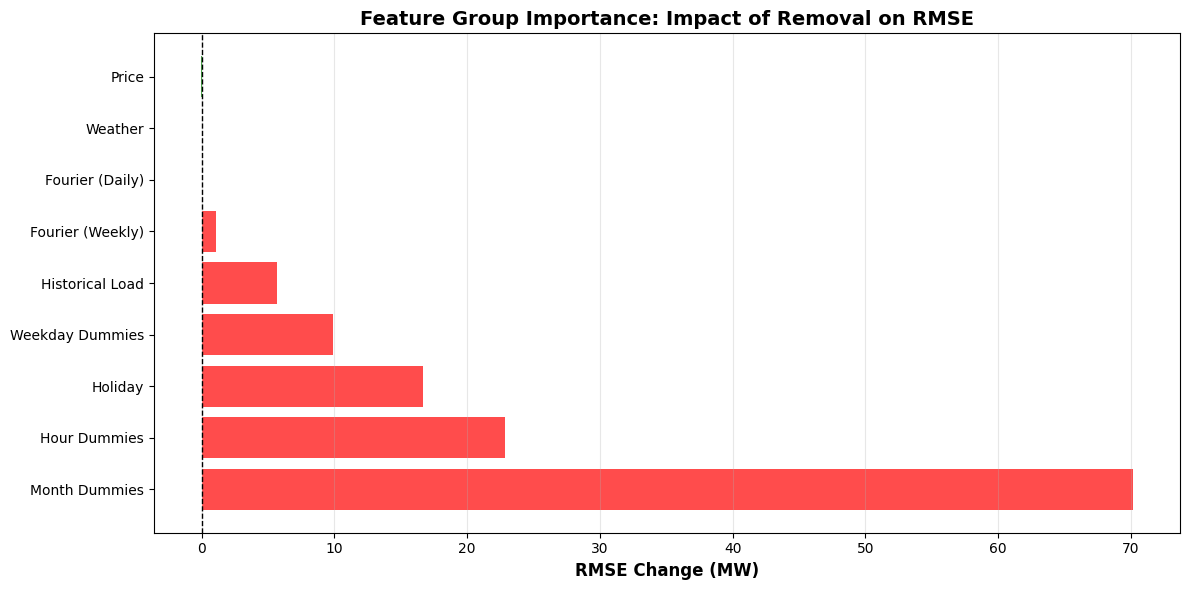

In [18]:
# visualize ablation impact
plt.figure(figsize=(12, 6))
colors = ['red' if x > 0 else 'green' for x in ablation_df['RMSE Change']]
plt.barh(ablation_df['Feature Group'], ablation_df['RMSE Change'], color=colors, alpha=0.7)
plt.xlabel('RMSE Change (MW)', fontweight='bold', fontsize=12)
plt.title('Feature Group Importance: Impact of Removal on RMSE', 
          fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Summary and Conclusions

In [19]:
print("="*80)
print("RQ2 ANALYSIS SUMMARY")
print("="*80)
print("\n1. MULTICOLLINEARITY:")
print(f"   - Features with high VIF (>10): {len(vif_data[vif_data['VIF'] >= 10])}")
print(f"   - Highly correlated pairs (|r|>0.7): {len(high_corr)}")

print("\n2. MOST IMPORTANT FEATURES (Bayesian Ridge):")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']}: {row['Coefficient']:.4f}")

print("\n3. FEATURE GROUPS WITH LARGEST IMPACT WHEN REMOVED:")
for i, row in ablation_df.head(5).iterrows():
    print(f"   - {row['Feature Group']}: +{row['RMSE Change']:.2f} MW ({row['RMSE % Change']:.1f}%)")

print("\n4. FEATURE GROUPS WITH MINIMAL IMPACT:")
for i, row in ablation_df.tail(3).iterrows():
    print(f"   - {row['Feature Group']}: {row['RMSE Change']:+.2f} MW ({row['RMSE % Change']:+.1f}%)")

print("\n" + "="*80)

RQ2 ANALYSIS SUMMARY

1. MULTICOLLINEARITY:
   - Features with high VIF (>10): 0
   - Highly correlated pairs (|r|>0.7): 1

2. MOST IMPORTANT FEATURES (Bayesian Ridge):
   - cos_day: -300.8835
   - 1w_load: 286.6756
   - month_4: -161.7987
   - month_10: -153.8572
   - month_5: -146.8620

3. FEATURE GROUPS WITH LARGEST IMPACT WHEN REMOVED:
   - Month Dummies: +70.20 MW (13.6%)
   - Hour Dummies: +22.85 MW (4.4%)
   - Holiday: +16.64 MW (3.2%)
   - Weekday Dummies: +9.86 MW (1.9%)
   - Historical Load: +5.70 MW (1.1%)

4. FEATURE GROUPS WITH MINIMAL IMPACT:
   - Fourier (Daily): +0.04 MW (+0.0%)
   - Weather: +0.01 MW (+0.0%)
   - Price: -0.09 MW (-0.0%)

